# Finetune ResNet50


With 1000 x 400 melspectrogram images normalized on the train set (instead of ImageNet stats) without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
FINETUNED_MODEL = 'resnet50_normalized'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Get the train set stats


In [14]:
import json

with open("../../../data/train_set_stats.json", "r") as f:
    stats = json.load(f)

mean = stats["mean"]
std = stats["std"]

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: [0.21260474622249603, 0.07653550803661346, 0.18260346353054047]
Std: [0.2794255018234253, 0.1220870390534401, 0.1852213442325592]


Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    # Normalize to the train set
    transforms.Normalize(mean=mean, std=std)
])

epochs = 25

C:\Users\profi\AppData\Local\Temp\ipykernel_23808\2243444212.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.83it/s, Loss=1.6343376636505127, Elapsed=20.0777s, ETA=0.0000s] 


Epoch 1 completed in 74.0688s
Train Loss: 1.4765206716653239 - Train Accuracy: 40.082766106600936
Validation Loss: 1.3411521991093953 - Validation Accuracy: 43.22498944702406

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.88it/s, Loss=1.3515403270721436, Elapsed=20.0806s, ETA=0.0000s] 


Epoch 2 completed in 72.7126s
Train Loss: 1.3070510215841966 - Train Accuracy: 45.59598380859772
Validation Loss: 1.3034592723846437 - Validation Accuracy: 45.409455466441536

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.98it/s, Loss=1.1946992874145508, Elapsed=19.8598s, ETA=0.0000s] 


Epoch 3 completed in 71.9971s
Train Loss: 1.2595075306864831 - Train Accuracy: 47.0432599895977
Validation Loss: 1.312556759516398 - Validation Accuracy: 44.406922752216126

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.82it/s, Loss=1.264857292175293, Elapsed=19.9580s, ETA=0.0000s]  


Epoch 4 completed in 71.8990s
Train Loss: 1.2301103391743808 - Train Accuracy: 48.16942176793831
Validation Loss: 1.2369184716542563 - Validation Accuracy: 47.119037568594344

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.86it/s, Loss=1.1522879600524902, Elapsed=19.9692s, ETA=0.0000s] 


Epoch 5 completed in 72.0460s
Train Loss: 1.2115999849545473 - Train Accuracy: 48.84104837068361
Validation Loss: 1.2589955997467042 - Validation Accuracy: 46.475306036302236

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.94it/s, Loss=1.2516978979110718, Elapsed=19.8245s, ETA=0.0000s] 


Epoch 6 completed in 71.7020s
Train Loss: 1.199272841042866 - Train Accuracy: 49.598606996675784
Validation Loss: 1.2126286657651266 - Validation Accuracy: 48.30097087378641

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.92it/s, Loss=1.0485496520996094, Elapsed=20.4572s, ETA=0.0000s] 


Epoch 7 completed in 72.3533s
Train Loss: 1.17755114343125 - Train Accuracy: 50.001130684516404
Validation Loss: 1.283531543413798 - Validation Accuracy: 47.80498100464331

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.91it/s, Loss=0.9431197047233582, Elapsed=19.9059s, ETA=0.0000s] 


Epoch 8 completed in 71.7739s
Train Loss: 1.1706370384017857 - Train Accuracy: 50.349381515569526
Validation Loss: 1.2156381654739379 - Validation Accuracy: 46.97129590544534

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.97it/s, Loss=1.1482168436050415, Elapsed=19.8861s, ETA=0.0000s] 


Epoch 9 completed in 71.8369s
Train Loss: 1.15753535504286 - Train Accuracy: 51.00065579701951
Validation Loss: 1.197713437875112 - Validation Accuracy: 47.57281553398058

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.90it/s, Loss=1.0832582712173462, Elapsed=19.7693s, ETA=0.0000s] 


Epoch 10 completed in 71.8957s
Train Loss: 1.1495291563127772 - Train Accuracy: 51.2154858551367
Validation Loss: 1.2005154236157736 - Validation Accuracy: 47.92106373997467

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.86it/s, Loss=0.9044251441955566, Elapsed=19.9348s, ETA=0.0000s] 


Epoch 11 completed in 71.7564s
Train Loss: 1.1457827254871413 - Train Accuracy: 51.3240315687117
Validation Loss: 1.2995988273620604 - Validation Accuracy: 44.79738286196707

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s, Loss=1.2775583267211914, Elapsed=19.9877s, ETA=0.0000s] 


Epoch 12 completed in 71.9053s
Train Loss: 1.1310495108882817 - Train Accuracy: 52.03862418308044
Validation Loss: 1.1915570108095805 - Validation Accuracy: 53.324187420852674

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.73it/s, Loss=1.202216625213623, Elapsed=20.0829s, ETA=0.0000s]  


Epoch 13 completed in 72.0595s
Train Loss: 1.1237850108243137 - Train Accuracy: 52.16526084891794
Validation Loss: 1.1898378976186117 - Validation Accuracy: 49.53566905867455

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.95it/s, Loss=0.9721128344535828, Elapsed=20.2033s, ETA=0.0000s] 


Epoch 14 completed in 72.2064s
Train Loss: 1.1203184193269367 - Train Accuracy: 52.122294837294504
Validation Loss: 1.1863583683967591 - Validation Accuracy: 50.105529759392155

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s, Loss=1.0124750137329102, Elapsed=19.9759s, ETA=0.0000s] 


Epoch 15 completed in 71.9103s
Train Loss: 1.1096191082386613 - Train Accuracy: 52.807489654236676
Validation Loss: 1.1539133548736573 - Validation Accuracy: 51.54073448712537

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.88it/s, Loss=1.0017048120498657, Elapsed=19.8474s, ETA=0.0000s] 


Epoch 16 completed in 71.7074s
Train Loss: 1.1068205344194622 - Train Accuracy: 52.79166007100699
Validation Loss: 1.180436290105184 - Validation Accuracy: 52.72266779231744

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.95it/s, Loss=1.1500729322433472, Elapsed=19.8783s, ETA=0.0000s] 


Epoch 17 completed in 71.8408s
Train Loss: 1.0982804043444594 - Train Accuracy: 53.08789941430542
Validation Loss: 1.1544646755854289 - Validation Accuracy: 52.25833685099198

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.96it/s, Loss=0.9802318215370178, Elapsed=19.7458s, ETA=0.0000s] 


Epoch 18 completed in 71.7199s
Train Loss: 1.089324772185673 - Train Accuracy: 53.531127744736665
Validation Loss: 1.1516907413800557 - Validation Accuracy: 53.38750527648797

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.97it/s, Loss=1.1035877466201782, Elapsed=19.7652s, ETA=0.0000s] 


Epoch 19 completed in 71.5963s
Train Loss: 1.0841159691355822 - Train Accuracy: 53.59444607765541
Validation Loss: 1.1922665158907573 - Validation Accuracy: 53.15533980582524

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.97it/s, Loss=1.3228063583374023, Elapsed=19.7912s, ETA=0.0000s] 


Epoch 20 completed in 71.6477s
Train Loss: 1.0835893297126526 - Train Accuracy: 53.58087786345854
Validation Loss: 1.1674662526448567 - Validation Accuracy: 53.165892781764455

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.95it/s, Loss=1.1136219501495361, Elapsed=19.8277s, ETA=0.0000s] 


Epoch 21 completed in 71.6200s
Train Loss: 1.0831914675029026 - Train Accuracy: 53.55148006603198
Validation Loss: 1.1858948310216268 - Validation Accuracy: 52.4799493457155

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.95it/s, Loss=0.9603180289268494, Elapsed=19.9160s, ETA=0.0000s] 


Epoch 22 completed in 71.8148s
Train Loss: 1.0726047139291819 - Train Accuracy: 54.048981253250716
Validation Loss: 1.1475241947174073 - Validation Accuracy: 49.556775010552975

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.83it/s, Loss=1.1407575607299805, Elapsed=19.9020s, ETA=0.0000s] 


Epoch 23 completed in 72.1352s
Train Loss: 1.0683246968109483 - Train Accuracy: 53.92234458741322
Validation Loss: 1.1599226260185242 - Validation Accuracy: 54.13676656817222

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.94it/s, Loss=1.0993266105651855, Elapsed=19.9081s, ETA=0.0000s] 


Epoch 24 completed in 72.6698s
Train Loss: 1.061232521010272 - Train Accuracy: 54.28868637072885
Validation Loss: 1.158131361802419 - Validation Accuracy: 52.849303503588004

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.91it/s, Loss=1.1474274396896362, Elapsed=19.8814s, ETA=0.0000s] 

Epoch 25 completed in 71.8298s
Train Loss: 1.055345590748539 - Train Accuracy: 54.64598267791321
Validation Loss: 1.136681354045868 - Validation Accuracy: 53.14478682988602



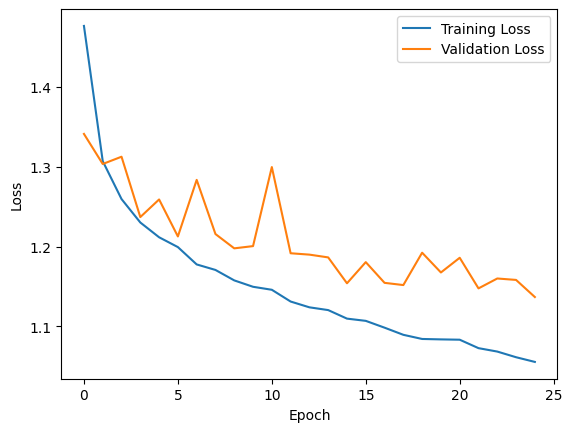

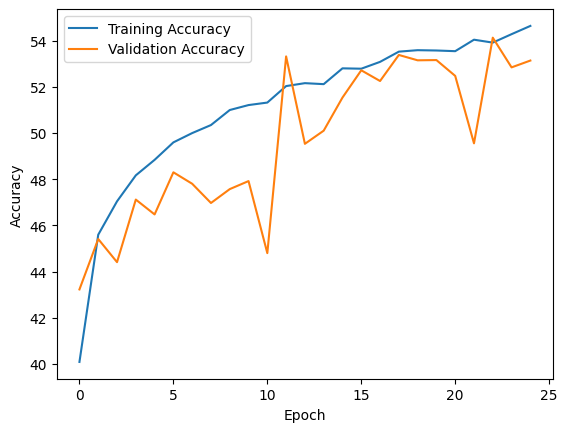

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [18]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_23808\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:21<00:00,  3.51it/s]


Test Results (Best Model):
Test Loss: 1.1491
Test Accuracy: 53.90%


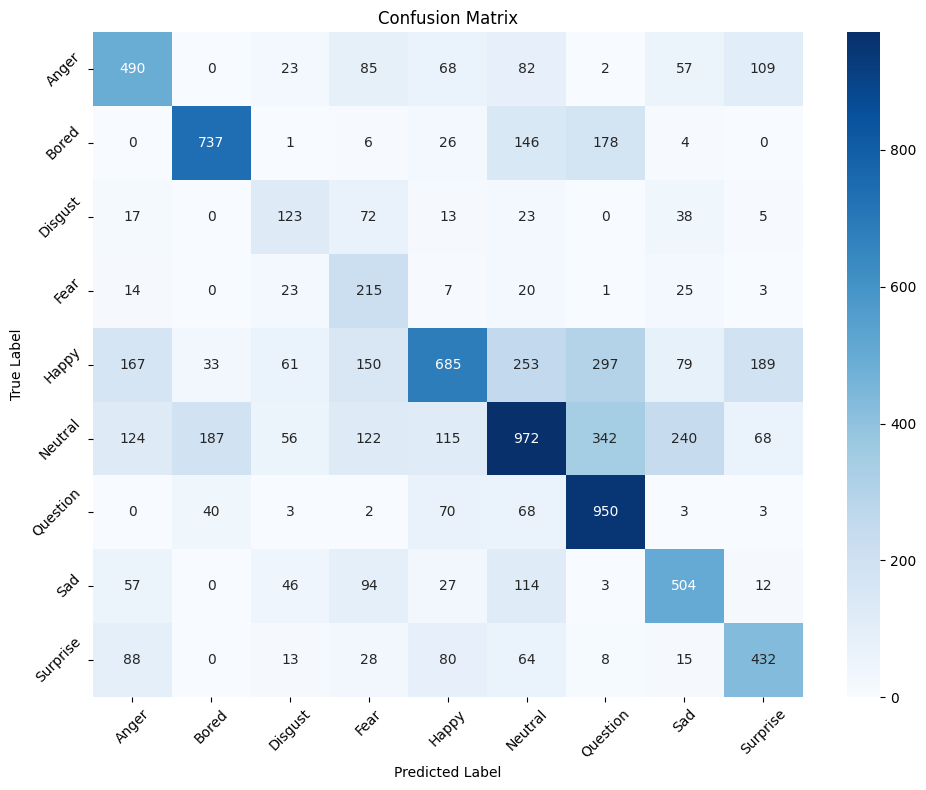

In [19]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)